In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Autocorrelation analysis & convergence

In this tutorial, we will discuss a method for convincing yourself that your chains are sufficiently converged.
This can be a difficult subject to discuss because it isn't formally possible to guarantee convergence for any but the simplest models, and therefore any argument that you make will be circular and heuristic.
However, some discussion of autocorrelation analysis is (or should be!) a necessary part of any publication using MCMC.

With emcee, we follow [Goodman & Weare (2010)](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml) and recommend using the *integrated autocorrelation time* to quantify the effects of sampling error on your results.
The basic idea is that the samples in your chain are not independent and you must estimate the effective number of independent samples.
There are other convergence diagnostics like the [Gelman–Rubin statistic](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/305.pdf) (*Note: you should not compute the G–R statistic using multiple chains in the same emcee ensemble because the chains are not independent!*) but, since the integrated autocorrelation time directly quantifies the Monte Carlo error (and hence the efficiency of the sampler) on any integrals computed using the MCMC results, it is the natural quantity of interest when judging the robustness of an MCMC analysis.

## Monte Carlo error

The goal of every MCMC analysis is to evaluate integrals of the form

$$
\mathrm{E}_{p(\theta)}[f(\theta)] = \int f(\theta)\,p(\theta)\,\mathrm{d}\theta \quad.
$$

If you had some way of generating $N$ samples $\theta^{(n)}$ from the probability density $p(\theta)$, then you could approximate this integral as

$$
\mathrm{E}_{p(\theta)}[f(\theta)] \approx \frac{1}{N} \sum_{n=1}^N f(\theta^{(n)})
$$

where the sum is over the samples from $p(\theta)$.
If these samples are independent, then the sampling variance on this estimator is

$$
\sigma^2 = \frac{1}{N}\,\mathrm{Var}_{p(\theta)}[f(\theta)]
$$

and the error decreses as $1/\sqrt{N}$ as you generate more samples.
In the case of MCMC, the samples are not independent and the error is actually given by

$$
\sigma^2 = \frac{\tau_f}{N}\,\mathrm{Var}_{p(\theta)}[f(\theta)]
$$

where $\tau_f$ is the *integrated autocorrelation time* for the chain $f(\theta^{(n)})$.
In other words, $N/\tau_f$ is the effective number of samples and $\tau_f$ is the number of steps that are needed before the chain "forgets" where it started.
This means that, if you can estimate $\tau_f$, then you can estimate the number of samples that you need to generate to reduce the relative error on your target integral to (say) a few percent.

**Note:** It is important to remember that $\tau_f$ depends on the specific function $f(\theta)$.
This means that there isn't just *one* integrated autocorrelation time for a given Markov chain.
Instead, you must compute a different $\tau_f$ for any integral you estimate using the samples.

## Computing autocorrelation times

There is a great discussion of methods for autocorrelation estimation in [a set of lecture notes by Alan Sokal](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf) and the interested reader should take a look at that for a more formal discussion, but I'll include a summary of some of the relevant points here.
The integrated autocorrelation time is defined as

$$
\tau_f = \sum_{\tau=-\infty}^\infty \rho_f(\tau)
$$

where $\rho_f(\tau)$ is the normalized autocorrelation function of the stochastic process that generated the chain for $f$.
You can estimate $\rho_f(\tau)$ using a finite chain $\{f_n\}_{n=1}^N$ as

$$
\hat{\rho}_f(\tau) = \hat{c}_f(\tau) / \hat{c}_f(0)
$$

where

$$
\hat{c}_f(\tau) = \frac{1}{N - \tau} \sum_{n=1}^{N-\tau} (f_n - \mu_f)\,(f_{n+\tau}-\mu_f)
$$

and

$$
\mu_f = \frac{1}{N}\sum_{n=1}^N f_n \quad.
$$

(Note: In practice, it is actually more computationally efficient to compute $\hat{c}_f(\tau)$ using a fast Fourier transform than summing it directly.)

Now, you might expect that you can estimate $\tau_f$ using this estimator for $\rho_f(\tau)$ as

$$
\hat{\tau}_f \stackrel{?}{=} \sum_{\tau=-N}^{N} \hat{\rho}_f(\tau) = 1 + 2\,\sum_{\tau=1}^N \hat{\rho}_f(\tau)
$$

but this isn't actually a very good idea.
At longer lags, $\hat{\rho}_f(\tau)$ starts to contain more noise than signal and summing all the way out to $N$ will result in a very noisy estimate of $\tau_f$.
Instead, we want to estimate $\tau_f$ as

$$
\hat{\tau}_f (M) = 1 + 2\,\sum_{\tau=1}^M \hat{\rho}_f(\tau)
$$

for some $M \ll N$.
As discussed by Sokal in the notes linked above, the introduction of $M$ decreases the variance of the estimator at the cost of some added bias and he suggests choosing the smallest value of $M$ where $M \ge C\,\hat{\tau}_f (M)$ for a constant $C \sim 5$.
Sokal says that he finds this procedure to work well for chains longer than $1000\,\tau_f$, but the situation is a bit better with emcee because we can use the parallel chains to reduce the variance and we've found that chains longer than about $50\,\tau$ are often sufficient.

## A toy problem

To demonstrate this method, we'll start by generating a set of "chains" from a process with known autocorrelation structure.
To generate a large enough dataset, we'll use [celerite](http://celerite.readthedocs.io):

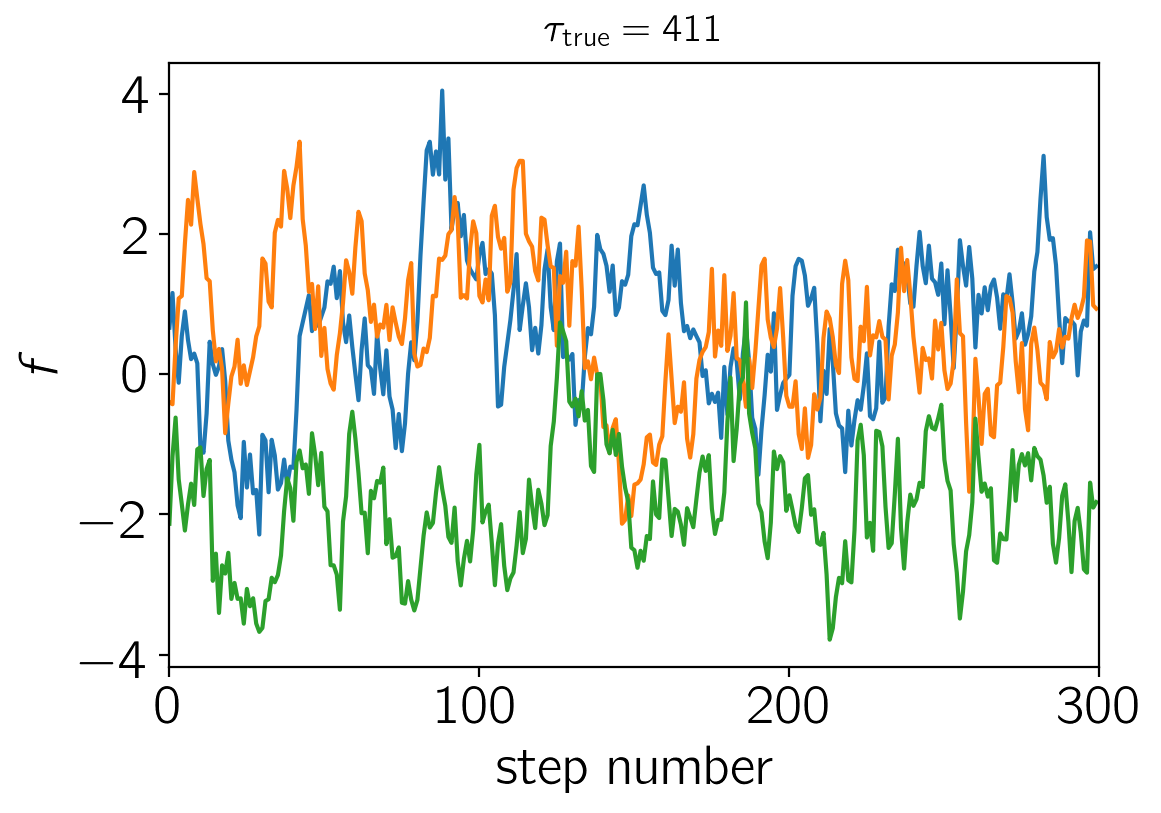

In [255]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123456)

# Build the celerite model:
import celerite
from celerite import terms
kernel = terms.RealTerm(log_a=0.0, log_c=-6.0)
kernel += terms.RealTerm(log_a=0.0, log_c=-2.0)

# The true autocorrelation time can be calculated analytically:
true_tau = sum(2*np.exp(t.log_a-t.log_c) for t in kernel.terms)
true_tau /= sum(np.exp(t.log_a) for t in kernel.terms)
true_tau

# Simulate a set of chains:
gp = celerite.GP(kernel)
t = np.arange(2000000)
gp.compute(t)
y = gp.sample(size=32)

# Let's plot a little segment with a few samples:
plt.plot(y[:3, :300].T)
plt.xlim(0, 300)
plt.xlabel("step number")
plt.ylabel("$f$")
plt.title("$\\tau_\mathrm{{true}} = {0:.0f}$".format(true_tau), fontsize=14);

Now we'll estimate the empirical autocorrelation function for each of these parallel chains and compare this to the true function.

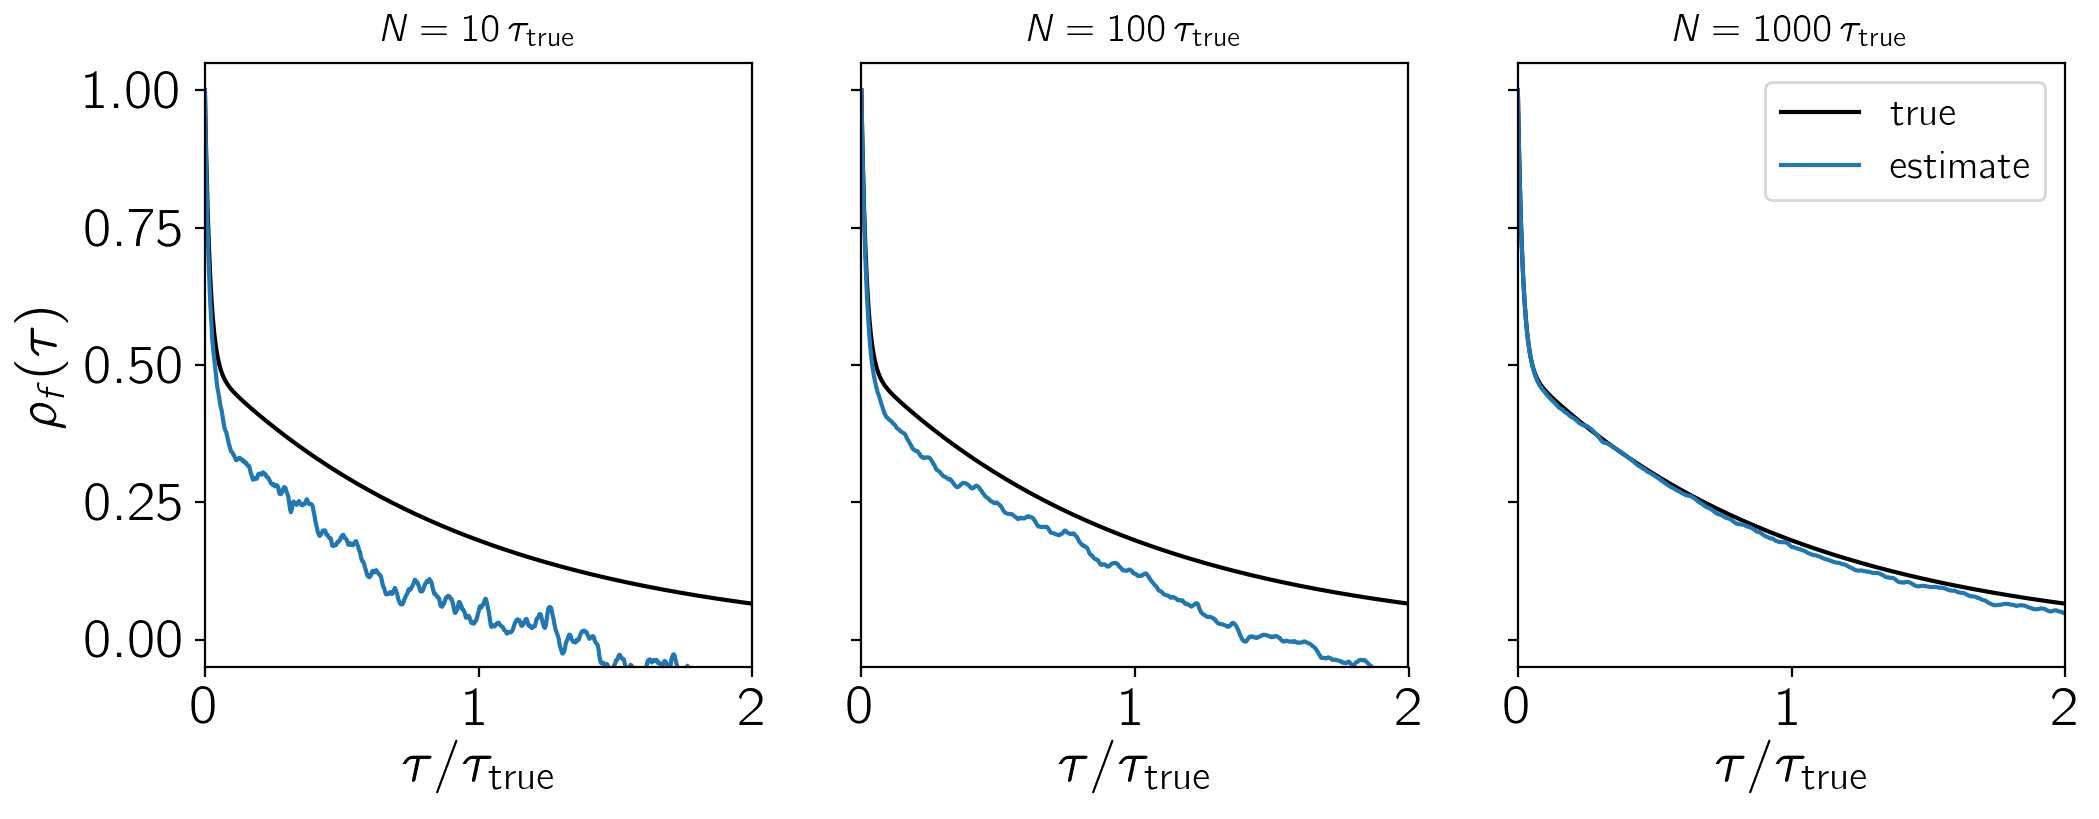

In [256]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Make plots of ACF estimate for a few different chain lengths
window = int(2*true_tau)
tau = np.arange(window+1)
f0 = kernel.get_value(tau) / kernel.get_value(0.0)

# Loop over chain lengths:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    ax.plot(tau / true_tau, autocorr_func_1d(y[0, :nn])[:window+1], label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

This figure shows how the empirical estimate of the normalized autocorrelation function changes as more samples are generated.
In each panel, the true autocorrelation function is shown as a black curve and the empricial estimator is shown as a blue line.

Instead of estimating the autocorrelation function using a single chain, we can assume that each chain is sampled from the same stochastic process and average the estimate over ensemble members to reduce the variance.
It turns out that we'll actually do this averaging later in the process below, but it can be useful to show the mean autocorrelation function for visualization purposes.

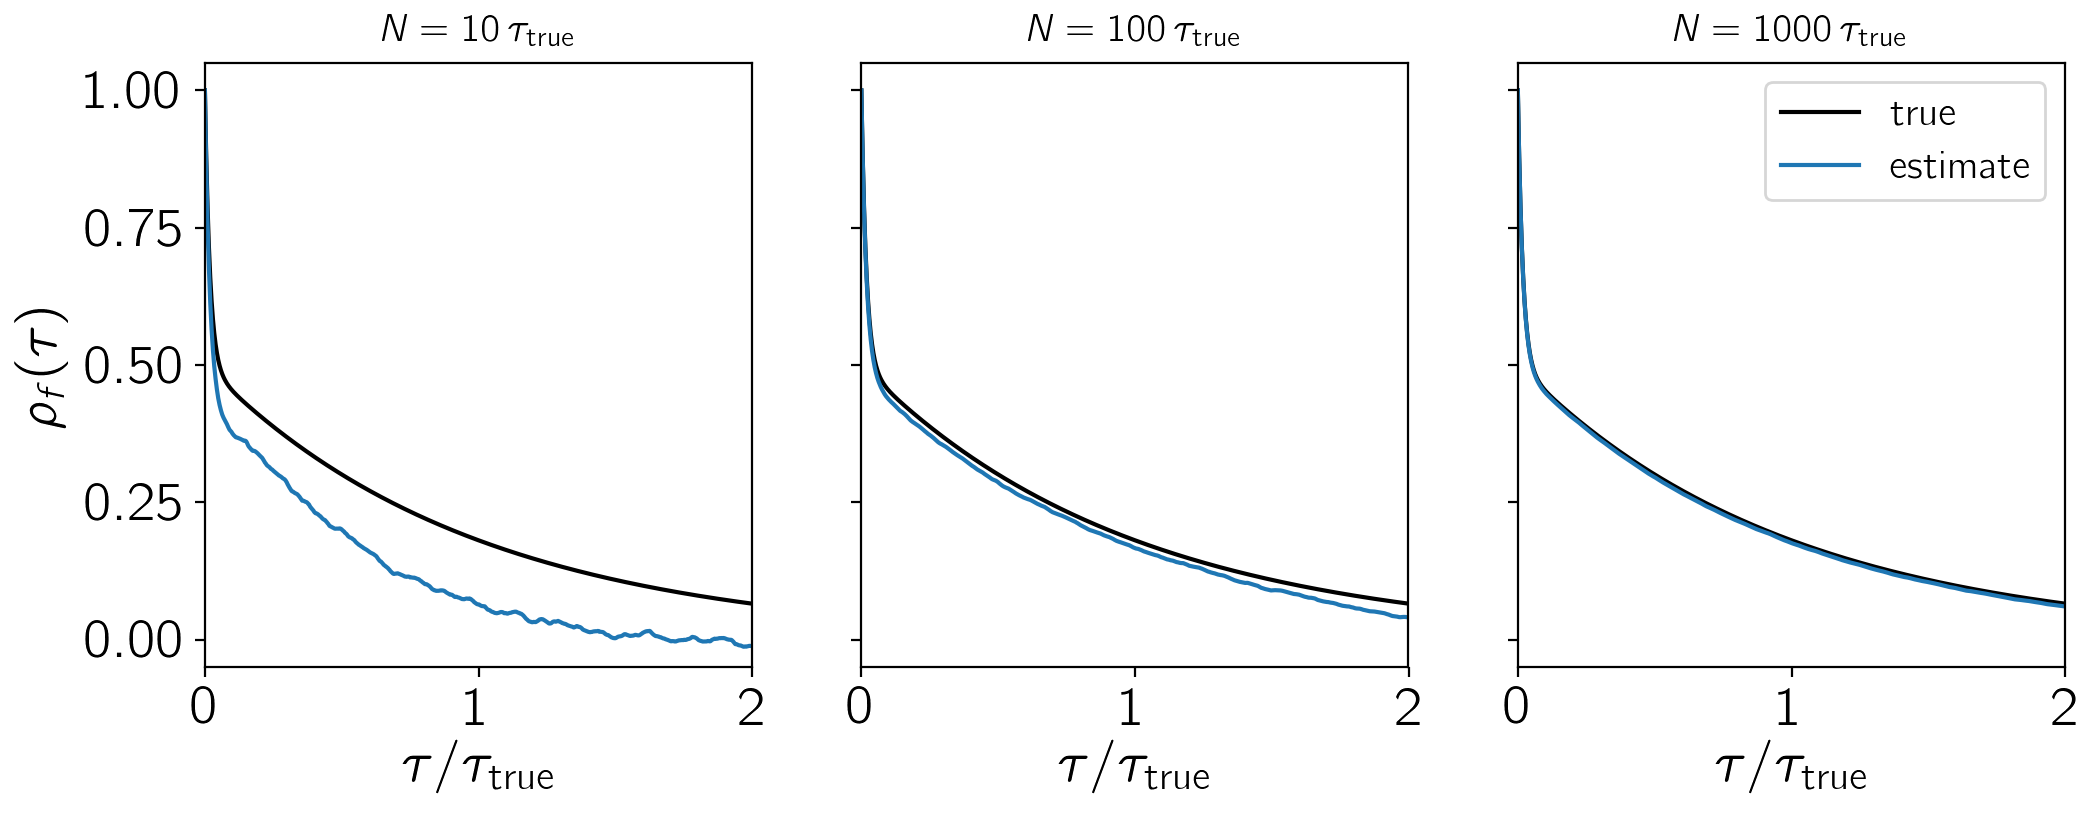

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    f = np.mean([autocorr_func_1d(y[i, :nn], norm=False)[:window+1]
                 for i in range(len(y))], axis=0)
    f /= f[0]
    ax.plot(tau / true_tau, f, label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

Now let's estimate the autocorrelation time using these estimated autocorrelation functions.
Goodman & Weare (2010) suggested averaging the ensemble over walkers and computing the autocorrelation function of the mean chain to lower the variance of the estimator and that was what was originally implemented in emcee.
Since then, @fardal on GitHub [suggested that other estimators might have lower variance](https://github.com/dfm/emcee/issues/209).
This is absolutely correct and, instead of the Goodman & Weare method, we now recommend computing the autocorrelation time for each walker (it's actually possible to still use the ensemble to choose the appropriate window) and then average these estimates.

Here is an implementation of each of these methods and a plot showing the convergence as a function of the chain length:

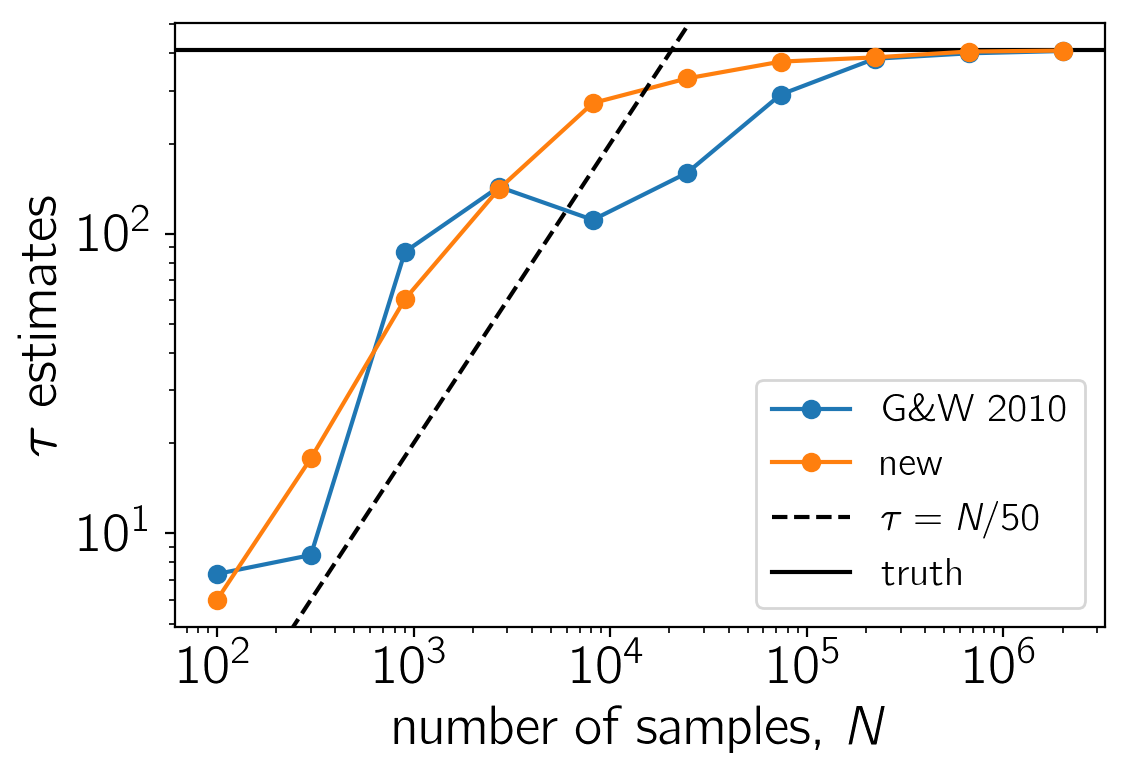

In [261]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

In this figure, the true autocorrelation time is shown as a horizontal line and it should be clear that both estimators give outrageous results for the short chains.
It should also be clear that the new algorithm has lower variance than the original method based on Goodman & Weare.
In fact, even for moderately long chains, the old method can give dangerously over-confident estimates.
For comparison, we have also plotted the $\tau = N/50$ line to show that, once the estimate crosses that line, The estimates are starting to get more reasonable.
This suggests that you probably shouldn't trust any estimate of $\tau$ unless you have more than $F\times\tau$ samples for some $F \ge 50$.
Larger values of $F$ will be more conservative, but they will also (obviously) require longer chains.

## A more realistic example

Now, let's run an actual Markov chain and test these methods using those samples.
So that the sampling isn't completely trivial, we'll sample a multimodal density in three dimensions.

In [263]:
import emcee

def log_prob(p):
    return np.logaddexp(-0.5*np.sum(p**2), -0.5*np.sum((p-4.0)**2))

sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(np.concatenate((np.random.randn(16, 3),
                                 4.0+np.random.randn(16, 3)), axis=0),
                 500000, progress=True);

100%|██████████| 500000/500000 [05:46<00:00, 1442.24it/s]


Here's the marginalized density in the first dimension.

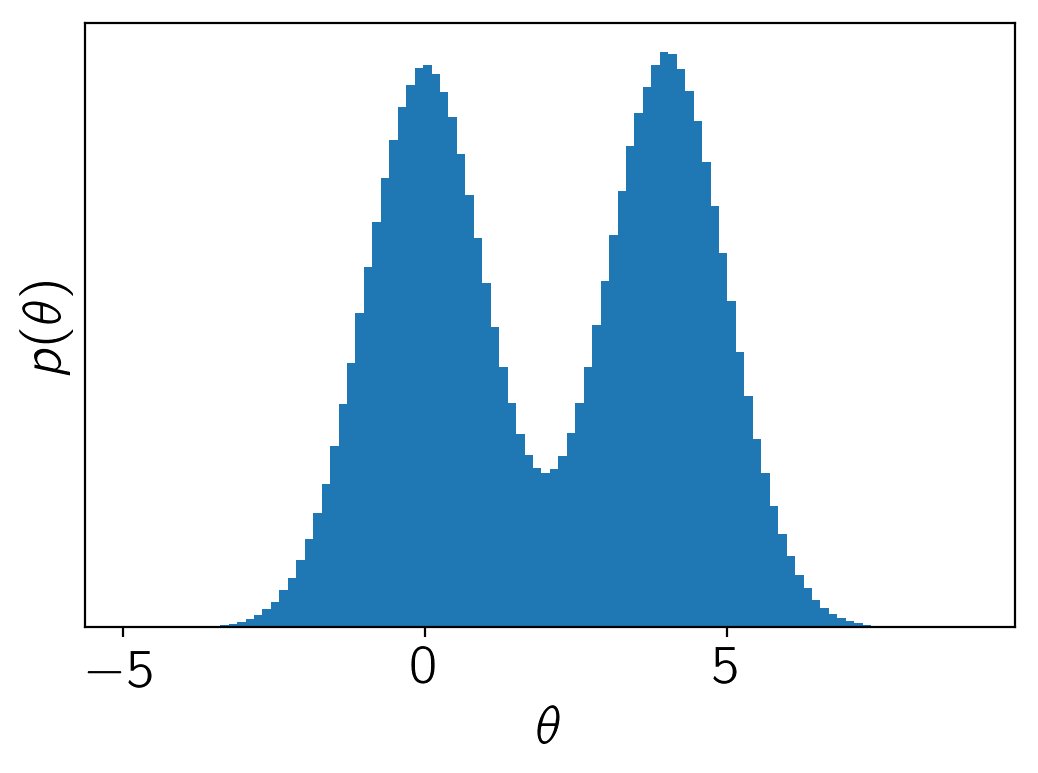

In [265]:
chain = sampler.get_chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

And here's the comparison plot showing how the autocorrelation time estimates converge with longer chains.

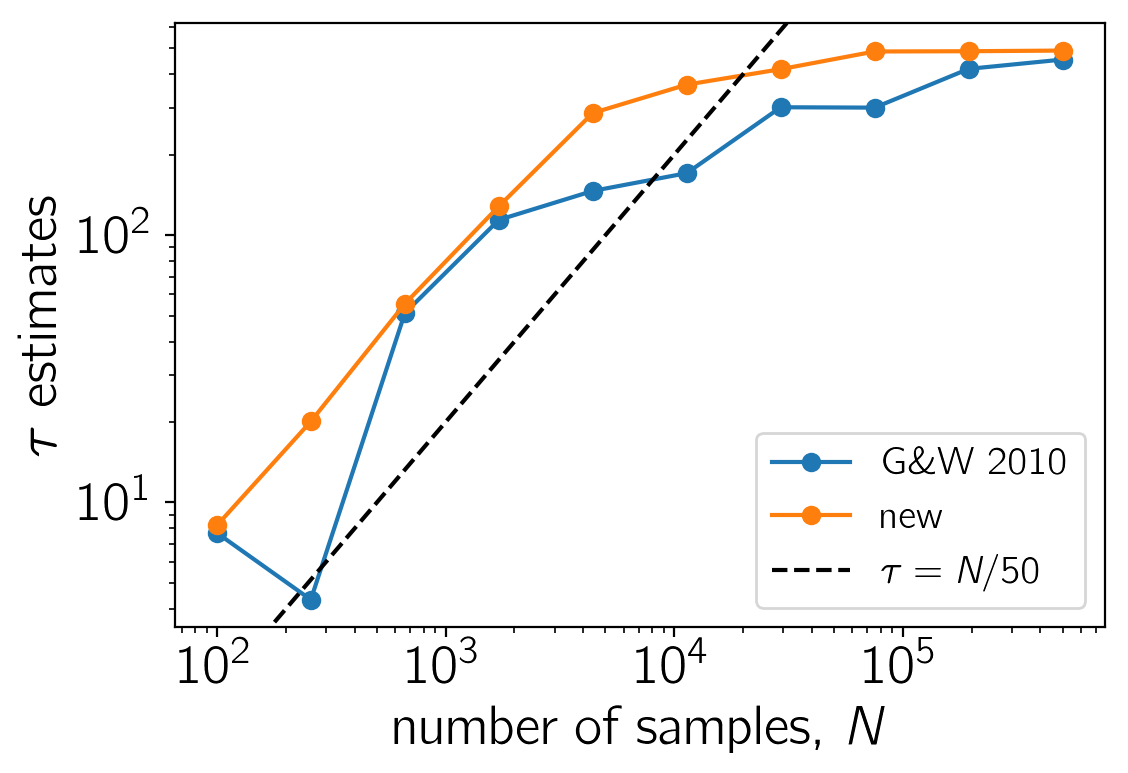

In [295]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

As before, the short chains give absurd estimates of $\tau$, but the new method converges faster and with lower variance than the old method.
The $\tau = N/50$ line is also included as above as an indication of where we might start trusting the estimates.

## What about shorter chains?

Sometimes it just might not be possible to run chains that are long enough to get a reliable estimate of $\tau$ using the methods described above.
In these cases, you might be able to get an estimate using parametric models for the autocorrelation.
One example would be to fit an [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) to the chain and using that to estimate the autocorrelation time.

As an example, we'll use [celerite](http://celerite.readthdocs.io) to fit for the maximum likelihood autocorrelation function and then compute an estimate of $\tau$ based on that model.
The celerite model that we're using is equivalent to a second-order ARMA model and it appears to be a good choice for this example, but we're not going to promise anything here about the general applicability and we caution care whenever estimating autocorrelation times using short chains.

In [365]:
from scipy.optimize import minimize

def autocorr_ml(y, thin=1, c=5.0):
    # Compute the initial estimate of tau using the standard method
    init = autocorr_new(y, c=c)
    z = y[:, ::thin]
    N = z.shape[1]
    
    # Build the GP model
    tau = max(1.0, init/thin)
    kernel = terms.RealTerm(np.log(0.9*np.var(z)), -np.log(tau),
                        bounds=[(-5.0, 5.0), (-np.log(N), 0.0)])
    kernel += terms.RealTerm(np.log(0.1*np.var(z)), -np.log(0.5*tau),
                            bounds=[(-5.0, 5.0), (-np.log(N), 0.0)])
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    # Define the objective
    def nll(p):
        # Update the GP model
        gp.set_parameter_vector(p)
        
        # Loop over the chains and compute likelihoods
        v, g = zip(*(
            gp.grad_log_likelihood(z0, quiet=True)
            for z0 in z
        ))
        
        # Combine the datasets
        return -np.sum(v), -np.sum(g, axis=0)

    # Optimize the model
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    gp.set_parameter_vector(soln.x)
    
    # Compute the maximum likelihood tau
    a, c = kernel.coefficients[:2]
    tau = thin * 2*np.sum(a / c) / np.sum(a)
    return tau

# Calculate the estimate for a set of different chain lengths
ml = np.empty(len(N))
ml[:] = np.nan
for j, n in enumerate(N[1:8]):
    i = j+1
    thin = max(1, int(0.05*new[i]))
    ml[i] = autocorr_ml(chain[:, :n], thin=thin)

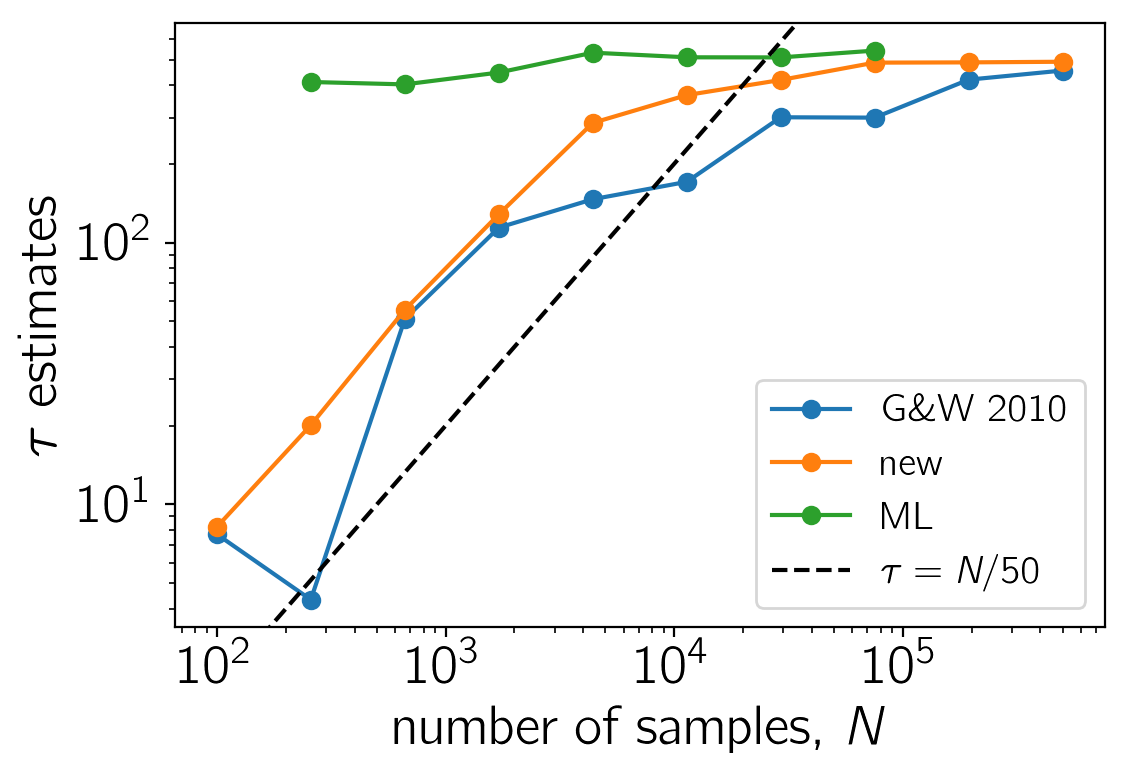

In [366]:
# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
plt.loglog(N, ml, "o-", label="ML")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

This figure is the same as the previous one, but we've added the maximum likelihood estimates for $\tau$ in green.
In this case, this estimate seems to be robust even for very short chains with $N \sim \tau$.